In [1]:
# various import statements
import numpy as np
import seaborn
import tqdm
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os
import pandas as pd
import re
import pybedtools
pybedtools.set_bedtools_path(path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniforge3/envs/sequences/bin/')
from pybedtools import BedTool
import cleanome
import cleanome.debug_gtf
from os.path import join as pjoin

# Synteny enrichment

Get synteny blocks across species with `./halSynteny /mnt/sda/primates_eichler-v2.hal /mnt/sda/qRhesustMouse.psl --queryGenome Rhesus --targetGenome Mouse`

Make toga annotation genes as single points at start.

Use pybedtools intersect start sites in synteny blocks of query species

For PSL: 10th,12th, and 13th columns are like BED on the query genome, and 14,16, and 17 are like BED on the target genome

In [ ]:
!/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/cactus-bin-v2.8.0/bin/halSynteny /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/genome/hal/447-mammalian-2022v1.hal --minBlockSize 50000 --maxAnchorDistance 50000 /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/synteny/qQtM.psl --queryGenome Macaca_mulatta --targetGenome Mus_musculus
!/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/cactus-bin-v2.8.0/bin/halSynteny /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/genome/hal/447-mammalian-2022v1.hal --minBlockSize 50000 --maxAnchorDistance 50000 /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/synteny/qMtQ.psl --queryGenome Mus_musculus --targetGenome Macaca_mulatta
!/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/cactus-bin-v2.8.0/bin/halSynteny /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/genome/hal/447-mammalian-2022v1.hal --minBlockSize 50000 --maxAnchorDistance 50000 /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/synteny/qMtH.psl --queryGenome Mus_musculus --targetGenome Homo_sapiens
!/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/cactus-bin-v2.8.0/bin/halSynteny /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/genome/hal/447-mammalian-2022v1.hal --minBlockSize 50000 --maxAnchorDistance 50000 /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/synteny/qHtM.psl --queryGenome Homo_sapiens --targetGenome Mus_musculus
!/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/cactus-bin-v2.8.0/bin/halSynteny /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/genome/hal/447-mammalian-2022v1.hal --minBlockSize 50000 --maxAnchorDistance 50000 /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/synteny/qQtH.psl --queryGenome Macaca_mulatta --targetGenome Homo_sapiens
!/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/cactus-bin-v2.8.0/bin/halSynteny /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/genome/hal/447-mammalian-2022v1.hal --minBlockSize 50000 --maxAnchorDistance 50000 /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/synteny/qHtQ.psl --queryGenome Homo_sapiens --targetGenome Macaca_mulatta

In [2]:
#./halSynteny /mnt/sda/primates_eichler-v2.hal /mnt/sda/qRhesustMouse.psl --queryGenome Rhesus --targetGenome Mouse
def GetSyntenicGenes(psl_file,bed_file):
    #Psl file should be query target output PSL from halSynteny
    #Bed file should be toga annotation file of query species
    qhtm=pd.read_csv(psl_file,sep='\t',header=None)
    
    query=pybedtools.BedTool.from_dataframe(qhtm.loc[:,[9,11,12]])
    #query=pybedtools.BedTool.from_dataframe(qhtm.loc[:,[13,15,16]])
    htab=pd.read_csv(bed_file,sep='\t',header=None)
    
    minus=htab[5]=='-'
    htab.loc[minus,1]=htab.loc[minus,2]
    htab.loc[~minus,2]=htab.loc[~minus,1]
  
    hbed=pybedtools.BedTool.from_dataframe(htab)
    intersection=hbed.intersect(query)
    l=[]
    for i in intersection:
        l.append(i.fields)

    return(pd.DataFrame(l))

In [3]:
#Run with halSynteny default except for min synteny block size=100kb
hbed='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/h_genes.bed'
qbed='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/q_genes.bed'
mbed='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/m_genes.bed'
synteny_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/synteny50k/'

qHtM_syntenic=GetSyntenicGenes(os.path.join(synteny_path,'qHtM.psl'),hbed)

qHtQ_syntenic=GetSyntenicGenes(os.path.join(synteny_path,'qHtQ.psl'),hbed)

qMtH_syntenic=GetSyntenicGenes(os.path.join(synteny_path,'qMtH.psl'),mbed)

qMtQ_syntenic=GetSyntenicGenes(os.path.join(synteny_path,'qMtQ.psl'),mbed)

qQtH_syntenic=GetSyntenicGenes(os.path.join(synteny_path,'qQtH.psl'),qbed)

qQtM_syntenic=GetSyntenicGenes(os.path.join(synteny_path,'qQtM.psl'),qbed)

***** WARNING: File /scratch/fast/16905877/pybedtools.b8q_qc0g.tmp has inconsistent naming convention for record:
chrM	7926	7928	ATP6	.	+

***** WARNING: File /scratch/fast/16905877/pybedtools.b8q_qc0g.tmp has inconsistent naming convention for record:
chrM	7926	7928	ATP6	.	+

***** WARNING: File /scratch/fast/16905877/pybedtools.osxsncd0.tmp has inconsistent naming convention for record:
chrM	7926	7928	ATP6	.	+

***** WARNING: File /scratch/fast/16905877/pybedtools.osxsncd0.tmp has inconsistent naming convention for record:
chrM	7926	7928	ATP6	.	+



In [4]:
qHtM_syntenic.to_csv(os.path.join(synteny_path,'qHtM_syntenic.tsv'),sep='\t')

qHtQ_syntenic.to_csv(os.path.join(synteny_path,'qHtQ_syntenic.tsv'),sep='\t')

qMtH_syntenic.to_csv(os.path.join(synteny_path,'qMtH_syntenic.tsv'),sep='\t')

qMtQ_syntenic.to_csv(os.path.join(synteny_path,'qMtQ_syntenic.tsv'),sep='\t')

qQtH_syntenic.to_csv(os.path.join(synteny_path,'qQtH_syntenic.tsv'),sep='\t')

qQtM_syntenic.to_csv(os.path.join(synteny_path,'qQtM_syntenic.tsv'),sep='\t')

# Gene Lengths and Flank Sizes

Are *gene deserts* actually **regulatory jungles**?

Use transcripts from H,Q,M Toga annotations, find the complement of genes. 

Merge and sort genes + complement.

Go along chromosomes and get the sizes of the intergenic regions to the left and right of each gene, as well as the mean size of transcripts associated with that gene.

In [2]:
gl_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists'

In [3]:
genome_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/genome/kallisto'
qGTF=cleanome.debug_gtf.polars_to_pandas(cleanome.debug_gtf.gtfparse_gtf_file(pjoin(genome_path,'CAT_chang','Rhesus.addgenes.gtf')))
hGTF=cleanome.debug_gtf.polars_to_pandas(cleanome.debug_gtf.gtfparse_gtf_file(pjoin(genome_path,'gencodev33','gencode.v33.annotation.gtf')))
mGTF=cleanome.debug_gtf.polars_to_pandas(cleanome.debug_gtf.gtfparse_gtf_file(pjoin(genome_path,'mm10','Mus_musculus.GRCm38.100.gtf')))

INFO:root:Extracted GTF attributes: ['transcript_id', 'gene_id', 'gene_name', 'exon_id']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


In [12]:
seaborn.histplot(np.log10(qGTF.loc[qGTF['feature']=='gene','end']-qGTF.loc[qGTF['feature']=='gene','start']))
seaborn.histplot(np.log10(hGTF.loc[hGTF['feature']=='gene','end']-hGTF.loc[hGTF['feature']=='gene','start']))
seaborn.histplot(np.log10(mGTF.loc[mGTF['feature']=='gene','end']-mGTF.loc[mGTF['feature']=='gene','start']))

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [5]:
qGTF=cleanome.debug_gtf.gtf_df_sort(qGTF)
qGTF=cleanome.debug_gtf.gtf_add_missing_features_optimized(qGTF)
qGTF=cleanome.debug_gtf.gtf_df_sort(qGTF)
qGTF.loc[qGTF['feature']=='gene',['seqname','start','end','gene_id','score','strand']].to_csv(pjoin(gl_path,'q_genes.bed'),header=False,sep='\t',index=False)

fix tx bug


1810699it [00:59, 30350.39it/s]
262216it [00:08, 32032.45it/s]
/home/matthew.schmitz/utils/cleanome/cleanome/debug_gtf.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[new_df['feature'] == 'exon', 'frame'] = '.'


fix tx bug


In [6]:
hGTF=cleanome.debug_gtf.gtf_add_missing_features_optimized(hGTF)
hGTF=cleanome.debug_gtf.gtf_df_sort(hGTF)
hGTF.loc[hGTF['feature']=='gene',['seqname','start','end','gene_id','score','strand']].to_csv(pjoin(gl_path,'h_genes.bed'),header=False,sep='\t',index=False)

1377112it [00:45, 30033.32it/s]
227912it [00:07, 32023.84it/s]
/home/matthew.schmitz/utils/cleanome/cleanome/debug_gtf.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[new_df['feature'] == 'exon', 'frame'] = '.'


fix tx bug


In [7]:
mGTF=cleanome.debug_gtf.gtf_add_missing_features_optimized(mGTF)
mGTF=cleanome.debug_gtf.gtf_df_sort(mGTF)
mGTF.loc[mGTF['feature']=='gene',['seqname','start','end','gene_id','score','strand']].to_csv(pjoin(gl_path,'m_genes.bed'),header=False,sep='\t',index=False)

843749it [00:28, 29854.90it/s]
142736it [00:04, 32104.70it/s]


fix tx bug


In [13]:
hG2G=dict(zip(hGTF['gene_id'],hGTF['gene_name']))
hG2G={x:hG2G[x] if hG2G[x] != '' else x for x in hG2G.keys()}
hT2G=dict(zip(hGTF['transcript_id'],hGTF['gene_id']))
hT2G={x:hT2G[x] if hT2G[x] != '' else x for x in hT2G.keys()}
qT2G=dict(zip(qGTF['transcript_id'],qGTF['gene_id']))
qT2G={x:qT2G[x] if qT2G[x] != '' else x for x in qT2G.keys()}
#qG2G=dict(zip(qGTF.loc[qGTF['feature']!='gene','gene_id'],qGTF.loc[qGTF['feature']!='gene','gene_name']))
#qG2G={x:qG2G[x] if qG2G[x] != '' else x for x in qG2G.keys()}
q=qGTF.loc[(qGTF['feature']!='gene')&(qGTF['gene_name']!=''),['gene_id','gene_name']]
qG2G=dict(zip(q['gene_id'],q['gene_name']))
mT2G=dict(zip(mGTF['transcript_id'],mGTF['gene_id']))
mT2G={x:mT2G[x] if mT2G[x] != '' else x for x in mT2G.keys()}
mG2G=dict(zip(mGTF['gene_id'],mGTF['gene_name']))
mG2G={x:mG2G[x] if mG2G[x] != '' else x for x in mG2G.keys()}

In [14]:
# df=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/genomes/cleanome_genomes/all_gene_ids.csv',header=0)
# mdict=dict(zip(df.loc[df['species']=='Mus_musculus','gene'],df.loc[df['species']=='Mus_musculus','ortholog_symbol']))

orthos=pd.read_csv('/home/matthew.schmitz/Matthew/genome/archaic/mm10/HOM_AllOrganism.rpt',sep='\t') #MGI ortholog table for mouse
orthos=orthos.loc[orthos['NCBI Taxon ID'].isin([10090,9606]),:]
classcounts=orthos['DB Class Key'].value_counts()
one2one=classcounts.index[list(classcounts==2)]
orthos=orthos.loc[orthos['DB Class Key'].isin(one2one),:]

htab=orthos.loc[orthos['NCBI Taxon ID']==9606,:]
mtab=orthos.loc[orthos['NCBI Taxon ID']==10090,:]
mdict=dict(zip(mtab['Symbol'],htab['Symbol']))

In [15]:
synteny_dir='synteny50k'
qHtQ_syntenic=pd.read_csv(pjoin(gl_path,synteny_dir,'qHtQ_syntenic.tsv'),sep='\t')
qQtH_syntenic=pd.read_csv(pjoin(gl_path,synteny_dir,'qQtH_syntenic.tsv'),sep='\t')
qHtM_syntenic=pd.read_csv(pjoin(gl_path,synteny_dir,'qHtM_syntenic.tsv'),sep='\t')
qMtH_syntenic=pd.read_csv(pjoin(gl_path,synteny_dir,'qMtH_syntenic.tsv'),sep='\t')
qQtM_syntenic=pd.read_csv(pjoin(gl_path,synteny_dir,'qQtM_syntenic.tsv'),sep='\t')
qMtQ_syntenic=pd.read_csv(pjoin(gl_path,synteny_dir,'qMtQ_syntenic.tsv'),sep='\t')

qHtQ_syntenic['3']=qHtQ_syntenic['3'].map(lambda x: hG2G.get(x,x))
qHtM_syntenic['3']=qHtM_syntenic['3'].map(lambda x: hG2G.get(x,x))

qMtQ_syntenic['3']=qMtQ_syntenic['3'].map(lambda x: mG2G.get(x,x))
qMtH_syntenic['3']=qMtH_syntenic['3'].map(lambda x: mG2G.get(x,x))

qQtM_syntenic['3']=qQtM_syntenic['3'].map(lambda x: qG2G.get(x,x))
qQtH_syntenic['3']=qQtM_syntenic['3'].map(lambda x: qG2G.get(x,x))

In [16]:
hbed='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/h_genes.bed'
qbed='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/q_genes.bed'
mbed='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/m_genes.bed'

h_bed=pd.read_csv(hbed,sep='\t',header=None)

m_bed=pd.read_csv(mbed,sep='\t',header=None)

q_bed=pd.read_csv(qbed,sep='\t',header=None)

In [17]:
h_bedtool=pybedtools.BedTool.from_dataframe(h_bed)
h_bedtool=h_bedtool.sort()
(h_bed.groupby(0)[2].max().sort_index(ascending=True)+1000).to_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_lengths/Human.from_bed.chromsizes',sep='\t')
h_comp=h_bedtool.complement(g='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_lengths/Human.from_bed.chromsizes')

In [18]:
m_bedtool=pybedtools.BedTool.from_dataframe(m_bed)
m_bedtool=m_bedtool.sort()
mbedmax=m_bed.groupby(0)[2].max()
mbedmax.index=mbedmax.index.astype(str)
(mbedmax.sort_index(ascending=True)+1000).to_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_lengths/Mouse.from_bed.chromsizes',sep='\t')
m_comp=m_bedtool.complement(g='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_lengths/Mouse.from_bed.chromsizes')

In [19]:
q_bedtool=pybedtools.BedTool.from_dataframe(q_bed)
q_bedtool=q_bedtool.sort()
(q_bed.groupby(0)[2].max().sort_index(ascending=True)+1000).to_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_lengths/Rhesus.from_bed.chromsizes',sep='\t')
q_comp=q_bedtool.complement(g='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_lengths/Rhesus.from_bed.chromsizes')

In [20]:
def fix_stupid_bt_columns(df):
    df.loc[0,:]=df.columns
    df.columns=list(range(len(df.columns)))
    return(df)

def get_lengths_and_intergenic(query_df,comp_df):
    query_df.columns=list(range(len(query_df.columns)))
    comp_df.columns=list(range(len(comp_df.columns)))
    query_df=query_df.drop(query_df.columns[4:],axis=1)
    query_df[1]=query_df[1].astype(int)
    query_df[2]=query_df[2].astype(int)
    comp_df[3]='intergenic'
    concatdf=pd.concat([comp_df,query_df],axis=0,ignore_index=True).sort_values(by=[0,1]).reset_index(drop=True)
    concatdf[1]=concatdf[1].astype(int)
    concatdf[2]=concatdf[2].astype(int)
    from collections import defaultdict
    stretches=defaultdict(lambda: defaultdict(int))
    last_gene=''
    for i in tqdm.tqdm(concatdf.index):
        gene=concatdf.loc[i,3]
        if gene==last_gene:
            stretches[gene]['end']=max(concatdf.loc[i,2],stretches[gene]['end'])
        elif gene!=last_gene:
            if 'start' in stretches[gene].keys():
                stretches[gene]['start']=min(concatdf.loc[i,1],stretches[gene]['start'])
            else:
                stretches[gene]['start']=concatdf.loc[i,1]
            stretches[gene]['end']=max(concatdf.loc[i,2],stretches[gene]['end'])
        if last_gene=='intergenic':
            stretches[gene]['left_flank']=np.abs(concatdf.loc[i-1,1]-concatdf.loc[i-1,2])
        if gene=='intergenic' and (i>0):
            stretches[concatdf.loc[i-1,3]]['right_flank']=np.abs(concatdf.loc[i,1]-concatdf.loc[i,2])
        last_gene=gene
    stretch_df=pd.DataFrame(stretches).T
    stretch_df['gene']=stretch_df.index.str.replace('^ENST[0-9]+\.','').str.replace('\.[0-9]*$','')
    stretch_df['gene_size']=np.abs(stretch_df['start']-stretch_df['end'])
    stretches_genes_df=pd.DataFrame([
        stretch_df.groupby('gene')['gene_size'].max(),
        stretch_df.groupby('gene')['left_flank'].min().fillna(0),
        stretch_df.groupby('gene')['right_flank'].min().fillna(0)
    ])
    return(stretches_genes_df.T.drop('intergenic'))

In [21]:
#Human doesn't include gene name in transcript
hdf=h_bedtool.to_dataframe(disable_auto_names=True,header=0)
#hdf.iloc[:,3]=[re.sub('\.','.'+y+'.',x) for x,y in zip(hdf.iloc[:,3],hdf.iloc[:,17])]#???

In [22]:
hdf

,chr1,11869,14409,ENSG00000223972.5,.,+
0,chr1,14404,29570,ENSG00000227232.5,.,-
1,chr1,17369,17436,ENSG00000278267.1,.,-
2,chr1,29554,31109,ENSG00000243485.5,.,+
3,chr1,30366,30503,ENSG00000284332.1,.,+
4,chr1,34554,36081,ENSG00000237613.2,.,-
...,...,...,...,...,...,...
60656,chrY,57184101,57197337,ENSG00000124334.17_PAR_Y,.,+
60657,chrY,57190738,57208756,ENSG00000270726.6_PAR_Y,.,+
60658,chrY,57201143,57203357,ENSG00000185203.12_PAR_Y,.,-
60659,chrY,57207346,57212230,ENSG00000182484.15_PAR_Y,.,+


In [23]:
q_length_intergenic=get_lengths_and_intergenic(q_bedtool.to_dataframe(disable_auto_names=True,header=None),
                                               q_comp.to_dataframe(disable_auto_names=True,header=None))
h_length_intergenic=get_lengths_and_intergenic(h_bedtool.to_dataframe(disable_auto_names=True),
                                               h_comp.to_dataframe(disable_auto_names=True))
m_length_intergenic=get_lengths_and_intergenic(m_bedtool.to_dataframe(disable_auto_names=True),
                                               m_comp.to_dataframe(disable_auto_names=True))

100%|██████████| 93882/93882 [00:02<00:00, 33881.78it/s]


In [24]:
q_length_intergenic.to_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_lengths/GeneSizeAndIntergenic_Q.tsv',sep='\t')
h_length_intergenic.to_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_lengths/GeneSizeAndIntergenic_H.tsv',sep='\t')
m_length_intergenic.to_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_lengths/GeneSizeAndIntergenic_M.tsv',sep='\t')

In [25]:
len_dir='gene_lengths'
hLen=pd.read_csv(pjoin(gl_path,len_dir,'GeneSizeAndIntergenic_H.tsv'),sep='\t')
qLen=pd.read_csv(pjoin(gl_path,len_dir,'GeneSizeAndIntergenic_Q.tsv'),sep='\t')
mLen=pd.read_csv(pjoin(gl_path,len_dir,'GeneSizeAndIntergenic_M.tsv'),sep='\t')

In [26]:
hLen['gene']=hLen['gene'].map(lambda x: hT2G.get(x,x)).map(lambda x: hG2G.get(x,x))
qLen['gene']=qLen['gene'].map(lambda x: qT2G.get(x,x)).map(lambda x: qG2G.get(x,x))
mLen['gene']=mLen['gene'].map(lambda x: mT2G.get(x,x)).map(lambda x: mdict.get(x,x)).map(lambda x: mG2G.get(x,x))

In [27]:
synteny_lists={'h':qHtM_syntenic['3'].unique(),
               'q':qQtM_syntenic['3'].unique(),
               'm':qMtH_syntenic['3'].unique(),
}

In [29]:
hLen['syntenic']=hLen['gene'].isin(synteny_lists['h'])
qLen['syntenic']=qLen['gene'].isin(synteny_lists['q'])
mLen['syntenic']=mLen['gene'].isin(synteny_lists['m'])

<Axes: xlabel='gene_size', ylabel='Count'>

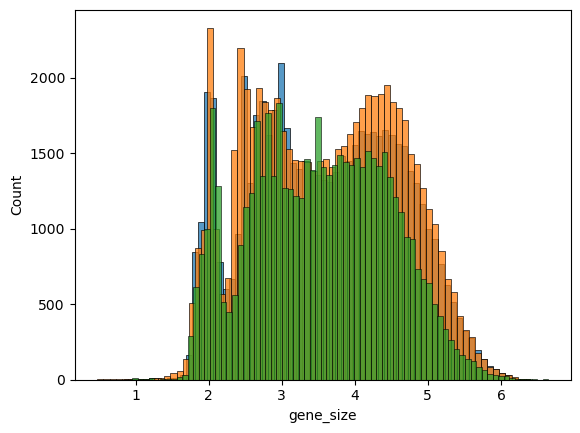

In [31]:
seaborn.histplot(np.log10(hLen['gene_size']))
seaborn.histplot(np.log10(qLen['gene_size']))
seaborn.histplot(np.log10(mLen['gene_size']))


In [32]:
hLen.to_csv(pjoin(gl_path,'human_lengths_synteny.txt'),sep='\t')
qLen.to_csv(pjoin(gl_path,'macaque_lengths_synteny.txt'),sep='\t')
mLen.to_csv(pjoin(gl_path,'mouse_lengths_synteny.txt'),sep='\t')


# Flanking Enhancers

Are *gene deserts* actually **regulatory jungles**? (Part 2)

Count the number of predicted enhancers flanking genes

Given a window of 100K from the start site, how many enhancers are contained?

# Transcription Factors

Are transcription factors regulated differently from other genes?

In [27]:
tf_list=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/TFs_lambert_pmid29425488_1.01.txt',sep='\t')

0       TFAP2A
1       TFAP2B
2       TFAP2C
3       TFAP2D
4       TFAP2E
         ...  
2760    ZNF738
2761    ZNF862
2762     ZNFX1
2763    ZRANB2
2764    ZFAND5
Name: HGNC symbol, Length: 2765, dtype: object

In [212]:
import gseapy as gp
gp.get_library_name()
print([x for x in  gp.get_library('GO_Molecular_Function_2023').keys() if 'ription' in x])
gp.get_library('GO_Molecular_Function_2023')['DNA-binding Transcription Factor Binding (GO:0140297)']
gp.get_library('GO_Molecular_Function_2023')['DNA-binding Transcription Activator Activity, RNA Polymerase II-specific (GO:0001228)']
gp.get_library('GO_Molecular_Function_2023')['DNA-binding Transcription Repressor Activity, RNA Polymerase II-specific (GO:0001227)']

ModuleNotFoundError: No module named 'gseapy'